## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
from util import *
import numpy as np
import matplotlib.pyplot as plt

import pacman as pm
from pacman import Directions
import layout as l
import textDisplay
import dqnAgent, ghostAgents

try:
    import boinc
    _BOINC_ENABLED = True
except:
    _BOINC_ENABLED = False

In [2]:
class Environment:
    def __init__(self, layout="mediumClassic"):
        self.layout = l.getLayout(layout)
        state_size = [1, self.layout.height, self.layout.width]
        self.beQuiet=True
        self.catchExceptions = False
        self.rules = pm.ClassicGameRules(timeout=30)
        self.pacman = dqnAgent.DQNAgent(state_size, action_size=5, seed=27)
        self.reset()

    def reset(self):
        self.display = textDisplay.NullGraphics()
        self.ghosts = [ghostAgents.RandomGhost(i+1) for i in range(self.layout.getNumGhosts())]
        self.agents = [self.pacman] + self.ghosts
        self.game = self.rules.newGame(self.layout, self.pacman, self.ghosts,
                                       self.display, self.beQuiet, self.catchExceptions)

        # inform learning agents of the game start
        for i in range(len(self.agents)):
            agent = self.game.agents[i]
            if not agent:
                self.game.mute(i)
                # this is a null agent, meaning it failed to load
                # the other team wins
                print("Agent %d failed to load" % i, file=sys.stderr)
                self.game.unmute()
                self.game._agentCrash(i, quiet=True)
                return

        self.agentIndex = self.game.startingIndex
        self.numAgents = len(self.game.agents)

    def get_current_state(self):
        return self.game.state.deepCopy()

    def get_reward(self):
        return env.game.state.getScore()

    def update_game_state(self, action):
        # Execute the action
        self.game.state = self.game.state.generateSuccessor( self.agentIndex, action )
        # Change the display
        self.game.display.update( self.game.state.data )
        # Allow for game specific conditions (winning, losing, etc.)
        self.game.rules.process(self.game.state, self.game)
        # Track progress
        if self.agentIndex == self.numAgents + 1: self.game.numMoves += 1
        # Next agent
        self.agentIndex = ( self.agentIndex + 1 ) % self.numAgents

        if _BOINC_ENABLED:
            boinc.set_fraction_done(self.game.getProgress())

    def convert_state_to_image(self, state):
        state = str(state).split("\n")[:-2]
        new_state = np.zeros((1, self.layout.height, self.layout.width))
        state_dict = {
            '%': 0, '.': 225, 'o': 255,
            'G': 50, '<': 75, '>': 75,
            '^': 75, 'v': 75, ' ': 150,
            'P': 75
        }

        for i in range(self.layout.height):
            for j in range(self.layout.width):
                new_state[0][i][j] = state_dict[state[i][j]]

        #new_state = new_state.reshape(-1)
        new_state /= 255.0

        return new_state

    def get_action_as_number(self, action):
        direction_to_action = {
            Directions.NORTH: 1,
            Directions.SOUTH: 2,
            Directions.EAST: 3,
            Directions.WEST: 4,
            Directions.STOP: 0
        }

        return direction_to_action[action]

    def step(self):
        initial_reward = self.get_reward()

        for agentIndex, agent in enumerate(self.game.agents):
            if not self.done():
                state = self.get_current_state()

                if agentIndex == 0:
                    state_as_image = self.convert_state_to_image(state)
                    legal = state.getLegalPacmanActions()
                    action = agent.getAction(state_as_image, legal)
                else:
                    action = agent.getAction(state)

                self.update_game_state(action)

                if agentIndex == 0:
                    state = state_as_image
                    action = self.get_action_as_number(action)
                    next_state = self.get_current_state()
                    next_state = self.convert_state_to_image(next_state)

                    reward = self.get_reward() - initial_reward
                    done = self.done()
                    agent.step(state, action, reward, next_state, done)

    def done(self, fast_check=False):
        if not self.game.gameOver:
            return False
        else:
            if fast_check: self.game.display.finish()
            return True

In [3]:
env = Environment()

Episode:  10 Average Score: -558.10
Episode:  20 Average Score: -578.75
Episode:  30 Average Score: -569.93
Episode:  40 Average Score: -567.02
Episode:  50 Average Score: -565.72
Episode:  60 Average Score: -563.23
Episode:  70 Average Score: -562.83
Episode:  80 Average Score: -565.74
Episode:  90 Average Score: -570.22
Episode:  100 Average Score: -569.79


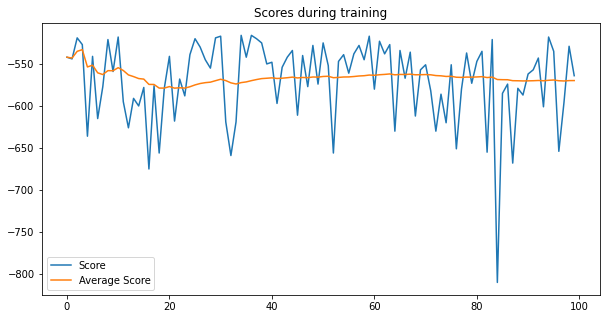

In [12]:
n_episodes = 100
print_every = 10
wins = []
scores = []
average_scores = []
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step()

    scores.append(env.game.state.getScore())
    wins.append(env.game.state.isWin())
    winRate = wins.count(True)/ float(len(wins))
    average_scores.append(sum(scores)/float(len(scores)))
    if i_episode == 0 or i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_scores[-1]))
        #print('Scores:       ', ', '.join([str(score) for score in scores]))
        #print('Win Rate:      %d/%d (%.2f)' % (wins.count(True), len(wins), winRate))
        #print('Record:       ', ', '.join([ ['Loss', 'Win'][int(w)] for w in wins]))

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
line1, = plt.plot(scores)
line2, = plt.plot(average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()